# 라쏘모델

## #01. 작업준비

### [1] 패키지 참조

In [18]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), '../../../../../'))
sys.path.append(work_path)
from helper.regrassion import *
from helper.plot import *
from helper.util import *
from helper.analysis import *
from sklearn.linear_model import Ridge, Lasso 

### [2] 데이터 가져오기

In [3]:
origin = my_read_excel("https://data.hossam.kr/mldata/fish.xlsx",info=False)
my_pretty_table(origin.head())

+----+--------+--------+--------+--------+
|    |   길이 |   높이 |   두께 |   무게 |
|----+--------+--------+--------+--------|
|  0 |    8.4 |   2.11 |   1.41 |    5.9 |
|  1 |   13.7 |   3.53 |      2 |     32 |
|  2 |     15 |   3.82 |   2.43 |     40 |
|  3 |   16.2 |   4.59 |   2.63 |   51.5 |
|  4 |   17.4 |   4.59 |   2.94 |     70 |
+----+--------+--------+--------+--------+


### [3] 데이터 표준화

In [4]:
std_df = my_standard_scaler(origin, yname='무게')
my_pretty_table(std_df.head())

+----+----------+----------+----------+--------+
|    |     길이 |     높이 |     두께 |   무게 |
|----+----------+----------+----------+--------|
|  0 | -2.18023 | -2.01651 | -1.89617 |    5.9 |
|  1 | -1.58743 |  -1.5187 | -1.56077 |     32 |
|  2 | -1.44203 | -1.41704 | -1.31633 |     40 |
|  3 | -1.30782 |  -1.1471 | -1.20263 |   51.5 |
|  4 |  -1.1736 |  -1.1471 | -1.02641 |     70 |
+----+----------+----------+----------+--------+


## #02. 선형회귀모형

앞 예제에서 확인한 과대적합 상태 재현하기 위해 차수가 3인 회귀모형을 구현한다.

### [1] 3차 항을 갖는 데이터 생성

In [5]:
poly_df = my_poly_features(std_df, ignore=['무게'], degree=3)
my_pretty_table(poly_df.head())

+----+----------+----------+----------+----------+-------------+-------------+----------+-------------+----------+----------+---------------+---------------+---------------+------------------+---------------+----------+---------------+---------------+----------+--------+
|    |     길이 |     높이 |     두께 |   길이^2 |   길이 높이 |   길이 두께 |   높이^2 |   높이 두께 |   두께^2 |   길이^3 |   길이^2 높이 |   길이^2 두께 |   길이 높이^2 |   길이 높이 두께 |   길이 두께^2 |   높이^3 |   높이^2 두께 |   높이 두께^2 |   두께^3 |   무게 |
|----+----------+----------+----------+----------+-------------+-------------+----------+-------------+----------+----------+---------------+---------------+---------------+------------------+---------------+----------+---------------+---------------+----------+--------|
|  0 | -2.18023 | -2.01651 | -1.89617 |  4.75338 |     4.39644 |     4.13409 |   4.0663 |     3.82365 |  3.59548 | -10.3634 |      -9.58523 |      -9.01324 |      -8.86545 |         -8.33642 |      -7.83895 | -8.19973 |      -7.71042 |      -7.25

### [2] 훈련, 검증 데이터 분리

In [6]:
x_train, x_test, y_train, y_test = my_train_test_split(poly_df, yname='무게', test_size=0.25)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((42, 19), (42,), (14, 19), (14,))

### [3] 다중 선형 회귀

앞 예제 제현

[교차검증]
+----+-------------------+
|    |   mean_test_score |
|----+-------------------|
|  0 |          0.506585 |
+----+-------------------+

[회귀식]
무게 = 183.647 * 길이 + 91.546 * 높이 + 15.900 * 두께 + -218.774 * 길이^2 + 1529.221 * 길이 높이 + -1065.606 * 길이 두께 + -431.260 * 높이^2 + -513.022 * 높이 두께 + 792.842 * 두께^2 + 2244.072 * 길이^3 + -9754.567 * 길이^2 높이 + 3469.316 * 길이^2 두께 + 5247.748 * 길이 높이^2 + 9298.437 * 길이 높이 두께 + -8799.181 * 길이 두께^2 + -643.099 * 높이^3 + -3710.045 * 높이^2 두께 + -516.396 * 높이 두께^2 + 3167.546 * 두께^3 + 279.431

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.996126 |     -1.79386 |
| 평균절대오차(MAE)             |      14.6008 |      180.092 |
| 평균제곱오차(MSE)             |      457.909 |       335421 |
| 평균오차(RMSE)                |      21.3988 |      579.155 |
| 평균 절대 백분오차 비율(MAPE) |      6.12734 |      44.4

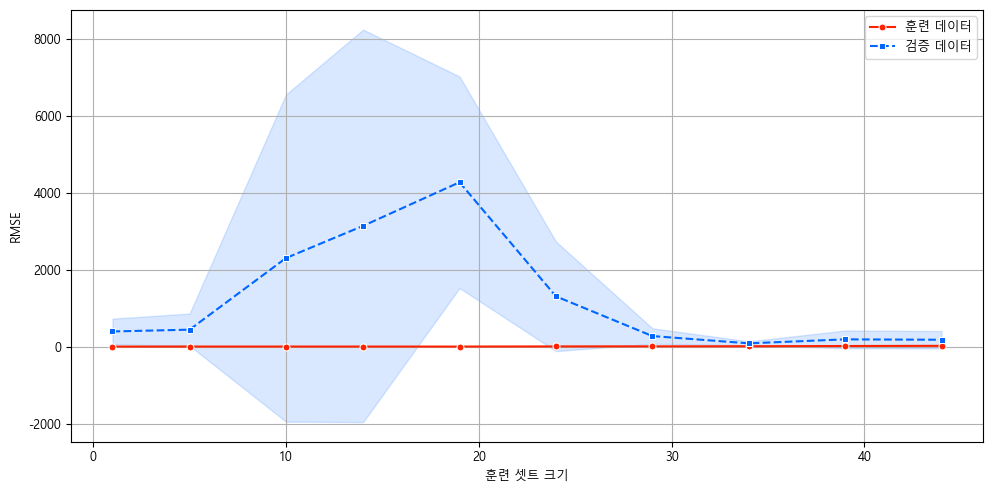

In [7]:
fit = my_linear_regrassion(x_train, y_train, x_test, y_test, cv=5, learning_curve=True, dpi=100)

## #03. 라쏘회귀모형

### [1] 기본 적용

일반적으로 선형 회귀 모델에 규제를 적용할 때 계수 값의 크기가 서로 많이 다르면 공정하게 제어되지 않을 수도 있다. 

그러므로 규제를 적용하기 전에 정규화를 먼저해야된다.

> 여기서는 데이터 분할 과정에서 미리 스케일링을 적용해 두었다.

#### (1) 모델 생성

In [8]:
model = Lasso()
fit = model.fit(x_train, y_train)
fit

Lasso()

#### (2) 결과 확인

릿지 회귀도 선형회귀의 일종이므로 미리 구현해둔 결과 확인 함수를 재사용 할 수 있다.

[교차검증]
+----+-------------------+
|    |   mean_test_score |
|----+-------------------|
|  0 |          0.506585 |
+----+-------------------+

[회귀식]
무게 = 183.647 * 길이 + 91.546 * 높이 + 15.900 * 두께 + -218.774 * 길이^2 + 1529.221 * 길이 높이 + -1065.606 * 길이 두께 + -431.260 * 높이^2 + -513.022 * 높이 두께 + 792.842 * 두께^2 + 2244.072 * 길이^3 + -9754.567 * 길이^2 높이 + 3469.316 * 길이^2 두께 + 5247.748 * 길이 높이^2 + 9298.437 * 길이 높이 두께 + -8799.181 * 길이 두께^2 + -643.099 * 높이^3 + -3710.045 * 높이^2 두께 + -516.396 * 높이 두께^2 + 3167.546 * 두께^3 + 279.431

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.996126 |     -1.79386 |
| 평균절대오차(MAE)             |      14.6008 |      180.092 |
| 평균제곱오차(MSE)             |      457.909 |       335421 |
| 평균오차(RMSE)                |      21.3988 |      579.155 |
| 평균 절대 백분오차 비율(MAPE) |      6.12734 |      44.4

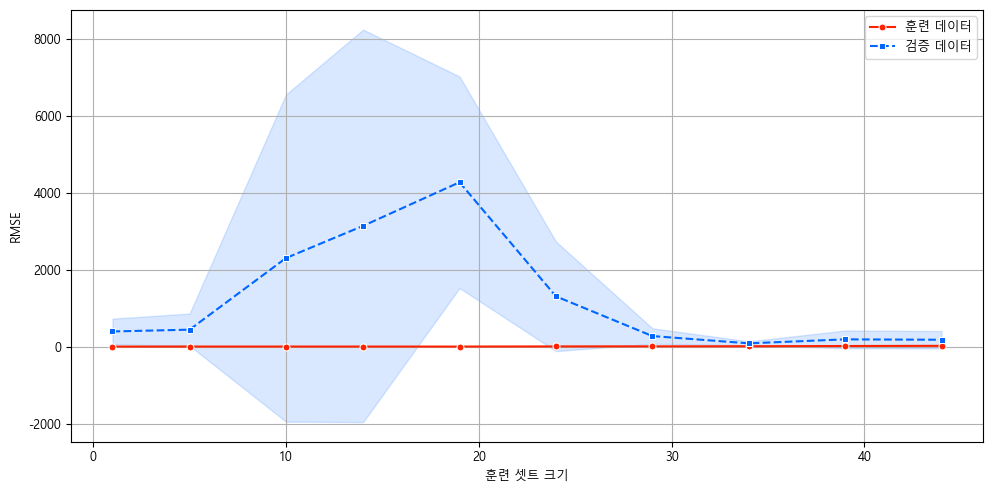


[독립변수보고]
+----+------------+----------------+--------------------+-------------+------------------+-----+------------+-------+
|    | 종속변수   | 독립변수       |   B(비표준화 계수) |    표준오차 |   β(표준화 계수) |   t |   유의확률 |   VIF |
|----+------------+----------------+--------------------+-------------+------------------+-----+------------+-------|
|  0 | 무게       | 길이           |            183.648 | 1.08128e+09 |            0.891 |   0 |        nan |   inf |
|  1 | 무게       | 높이           |            91.5465 | 8.76234e+08 |           -1.223 |   0 |        nan |   inf |
|  2 | 무게       | 두께           |            15.9005 | 2.04909e+09 |            1.173 |   0 |        nan |   inf |
|  3 | 무게       | 길이^2         |           -218.774 | 5.16759e+09 |            0.655 |  -0 |        nan |   inf |
|  4 | 무게       | 길이 높이      |            1529.22 | 9.26012e+09 |           -0.111 |   0 |        nan |   inf |
|  5 | 무게       | 길이 두께      |           -1065.61 |         nan |           -0.064 | nan |     

c:\Users\Jihwan\Desktop\01Class\helper\regrassion.py:327: RuntimeWarning: invalid value encountered in sqrt
  se_b = np.sqrt(MSE * dia)           # 표준오차
c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


LinearRegression(n_jobs=-1)

In [9]:
my_linear_regrassion(x_train=x_train, y_train= y_train, x_test=x_test, y_test=y_test,report=True, dpi=100)

### [2] 규제 조절하기

릿지모델을 사용할 때 규제의 양을 임의로 조절할 수 있다. 

모델 객체를 만들 때 alpha 생성자 파라미터로 규제의 강도를 조절한다.

- alpha값이 크면 규제 강도가 세지므로 계수 값을 더 줄이고 조금 더 과소적합되도록 유도한다.
- alpha값이 작으면 계수를 줄이는 역할이 줄어들고 선형 회귀 모델과 유사해지므로 과대적합될 가능성이 크다.

> alpha 값은 정해진 값이 없으며 데이터에 따라 달라지므로 분석을 수행할 때 마다 최적의 값을 분석가가 찾아야 한다.

#### 하이퍼파라미터(hyperparameter)

alpha 값은 릿지 모델이 학습하는 것이 아니라 개발자가 지정해야 하는 값이다. 

이렇게 머신러닝 모델이 학습할 수 없고 직접 정해야 하는 파라미터를 하이퍼파라미터(hyperparameter)라고 부른다.

사이킷런과 같은 머신러닝 라이브러리에서 하이퍼파라미터는 클래스와 매서드의 매개변수로 표현된다.

In [10]:
train_score = []
test_score = []
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alpha_list:
    model = Lasso(alpha=alpha)
    fit = model.fit(x_train, y_train)
    train_score.append(fit.score(x_train, y_train))
    test_score.append(fit.score(x_test, y_test))

train_score, test_score

c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e+04, tolerance: 4.965e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e+04, tolerance: 4.965e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

([0.9911272113873515,
  0.9911019411515,
  0.9904818542126257,
  0.9888403797472183,
  0.9847375681974455,
  0.8317453575389402],
 [0.9851979840186906,
  0.9853091255219942,
  0.9881260499964207,
  0.9872398135790703,
  0.9746839127639272,
  0.3038775570344302])

#### (2) 학습 결과 시각화

$x$축으로 사용하는 `alpha_list` 간격이 일정하지 않기 때문에 그래프가 한쪽으로 치우쳐 나와 판별이 어렵다.

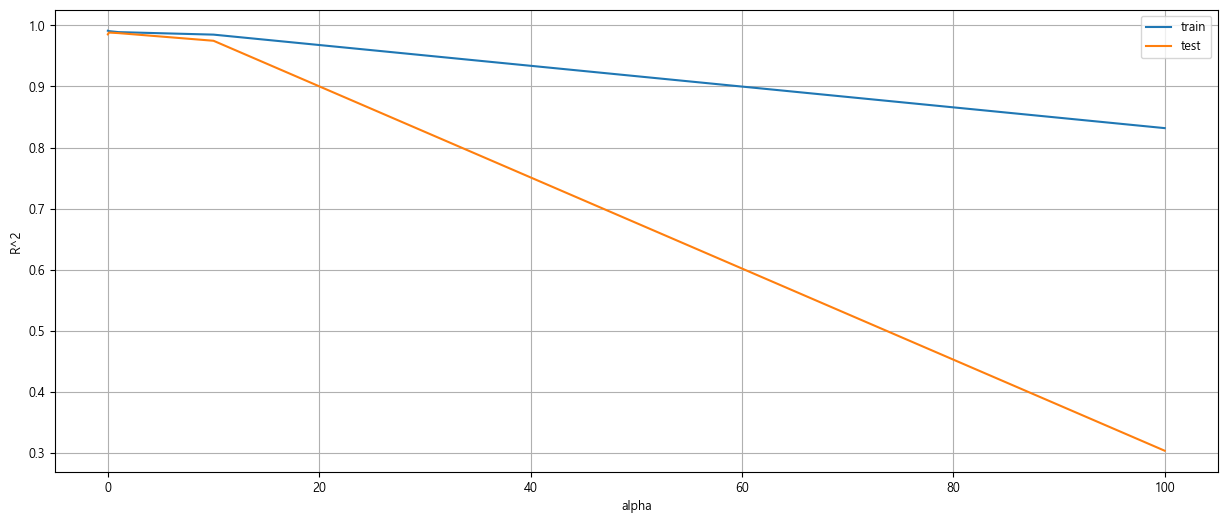

In [11]:
plt.figure(dpi=100)

# 훈련데이터 스코어
sb.lineplot(x = alpha_list, y=train_score, label='train')

# 검증데이터 스코어
sb.lineplot(x=alpha_list, y=test_score, label='test')

plt.xlabel('alpha')
plt.ylabel('R^2')
plt.grid()
plt.show()
plt.close()

#### (3) 학습 결과 시각화

$x$축으로 간격을 균일하게 변환하기 위해 로그 적용

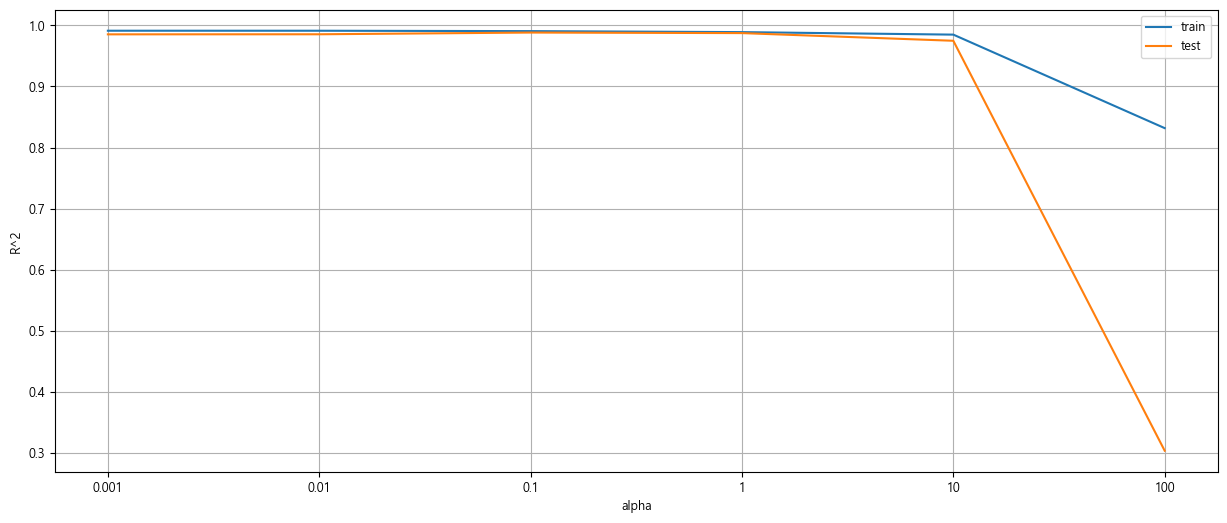

In [12]:
xticks = []
for i in range(-3, -3+len(alpha_list)):
    xticks.append(i)

plt.figure(dpi=100)
sb.lineplot(x=np.log10(alpha_list), y=train_score, label='train')
sb.lineplot(x=np.log10(alpha_list), y=test_score, label='test')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.xticks(xticks, alpha_list)
plt.grid()
plt.show()
plt.close()

#### (4) 최적의 하이퍼 파라미터를 적용한 최종 모델 도출

c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.023e+04, tolerance: 4.965e+02
  model = cd_fast.enet_coordinate_descent(


[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.990482 |     0.988126 |
| 평균절대오차(MAE)             |      24.7195 |      25.3134 |
| 평균제곱오차(MSE)             |      1125.15 |      1425.55 |
| 평균오차(RMSE)                |      33.5433 |      37.7564 |
| 평균 절대 백분오차 비율(MAPE) |      9.99274 |      28.7059 |
| 평균 비율 오차(MPE)           |    -0.893969 |      24.5462 |
+-------------------------------+--------------+--------------+

[학습곡선]


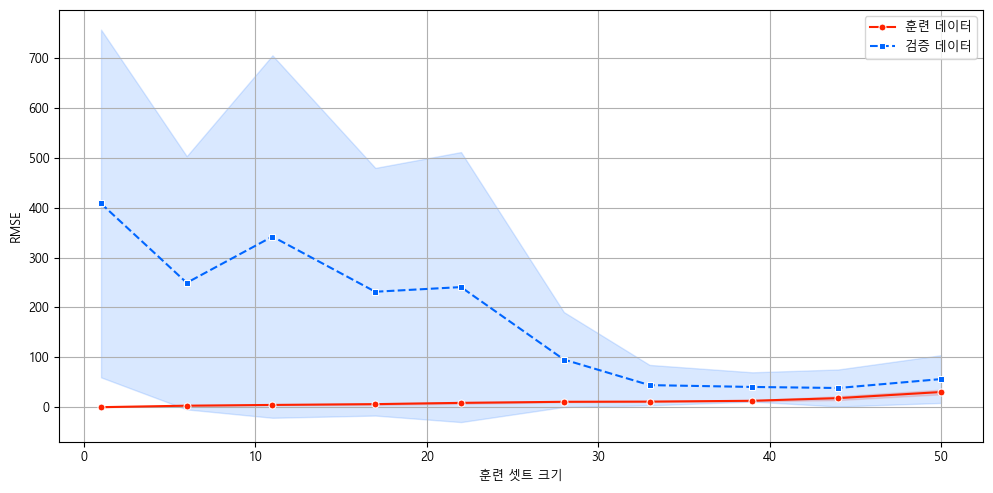

In [13]:
model = Lasso(alpha=0.1)
fit = model.fit(x_train, y_train)
my_linear_regrassion_result(fit, x_train=x_train, y_train=y_train, x_test=x_test,y_test=y_test, dpi=100)

## #04. 최적의 하이퍼 파라미터 찾기

In [14]:
# 찾고자 하는 파라미터 후보
params = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}

# 모델 객체를 생성할 때는 찾아야 하는 파라미터를 지정하지 않음
model = Lasso()

#GridSearchCV를 생성
grid = GridSearchCV(model, param_grid= params, cv=10, n_jobs=-1)
fit = grid.fit(x_train, y_train)

result_df = DataFrame(grid.cv_results_['params'])
result_df['mean_test_score'] = grid.cv_results_['mean_test_score']
my_pretty_table(result_df.sort_values(by='mean_test_score', ascending = False))


+----+---------+-------------------+
|    |   alpha |   mean_test_score |
|----+---------+-------------------|
|  4 |      10 |          0.966189 |
|  3 |       1 |          0.959957 |
|  2 |     0.1 |          0.948106 |
|  1 |    0.01 |          0.936667 |
|  0 |   0.001 |          0.934993 |
|  5 |     100 |           0.65352 |
+----+---------+-------------------+


[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.984738 |     0.974684 |
| 평균절대오차(MAE)             |      31.5787 |      41.5944 |
| 평균제곱오차(MSE)             |      1804.19 |      3039.36 |
| 평균오차(RMSE)                |      42.4758 |      55.1304 |
| 평균 절대 백분오차 비율(MAPE) |      14.4074 |       142.43 |
| 평균 비율 오차(MPE)           |     -1.11066 |      126.546 |
+-------------------------------+--------------+--------------+

[학습곡선]


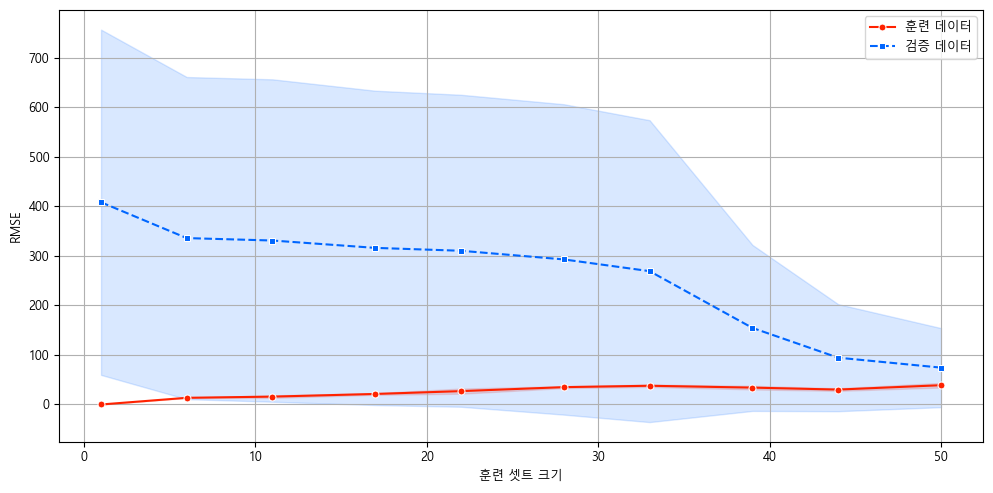

In [15]:
my_linear_regrassion_result(fit.best_estimator_, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,dpi=100)

## #05. 라쏘 모형에 대한 GridSearchCV 모듈화 확인

[Lasso 하이퍼파라미터]
+----+---------+
|    |   alpha |
|----+---------|
|  0 |    0.01 |
|  1 |     0.1 |
|  2 |       1 |
|  3 |      10 |
|  4 |     100 |
+----+---------+

[교차검증]
+----+---------+-------------------+
|    |   alpha |   mean_test_score |
|----+---------+-------------------|
|  3 |      10 |          0.973708 |
|  2 |       1 |          0.971065 |
|  1 |     0.1 |          0.959327 |
|  0 |    0.01 |          0.952801 |
|  4 |     100 |          0.753163 |
+----+---------+-------------------+

[회귀식]
무게 = 104.927 * 길이 + 67.733 * 높이 + 85.589 * 두께 + 5.185 * 길이^2 + 64.408 * 길이 높이 + 0.000 * 길이 두께 + 2.040 * 높이^2 + 0.000 * 높이 두께 + 0.000 * 두께^2 + 0.000 * 길이^3 + 0.000 * 길이^2 높이 + 0.000 * 길이^2 두께 + 0.000 * 길이 높이^2 + 0.000 * 길이 높이 두께 + 0.000 * 길이 두께^2 + 23.097 * 높이^3 + 0.000 * 높이^2 두께 + 0.000 * 높이 두께^2 + 0.000 * 두께^3 + 298.095

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|----------------------------

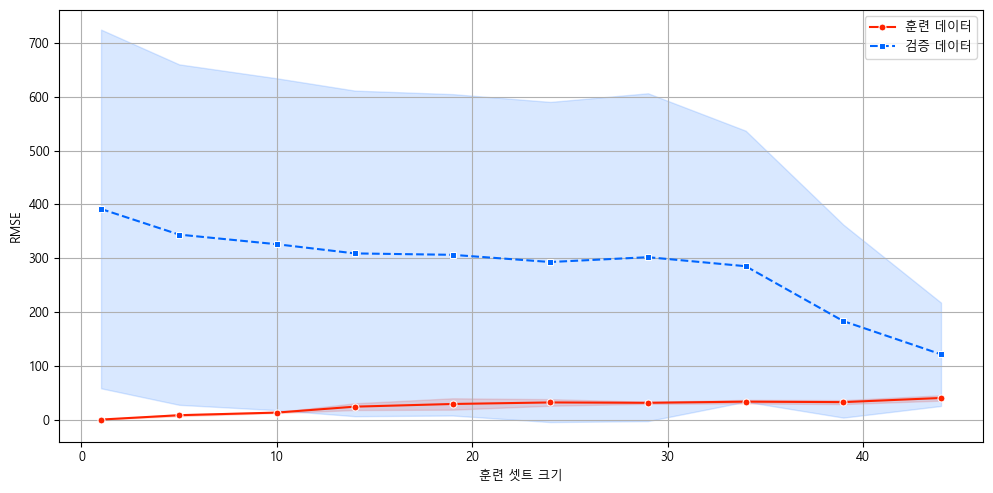


[독립변수보고]
+----+------------+----------------+--------------------+-------------+------------------+-----+------------+-------+
|    | 종속변수   | 독립변수       |   B(비표준화 계수) |    표준오차 |   β(표준화 계수) |   t |   유의확률 |   VIF |
|----+------------+----------------+--------------------+-------------+------------------+-----+------------+-------|
|  0 | 무게       | 길이           |            104.927 | 1.02928e+08 |            0.891 |   0 |        nan |   inf |
|  1 | 무게       | 높이           |            67.7331 | 8.34097e+07 |           -1.223 |   0 |        nan |   inf |
|  2 | 무게       | 두께           |             85.589 | 1.95055e+08 |            1.173 |   0 |        nan |   inf |
|  3 | 무게       | 길이^2         |             5.1849 | 4.91908e+08 |            0.655 |   0 |        nan |   inf |
|  4 | 무게       | 길이 높이      |            64.4076 |  8.8148e+08 |           -0.111 |   0 |        nan |   inf |
|  5 | 무게       | 길이 두께      |                  0 |         nan |           -0.064 | nan |     

c:\Users\Jihwan\Desktop\01Class\helper\regrassion.py:423: RuntimeWarning: invalid value encountered in sqrt
  fit.adj_r2 = adj_r2
c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


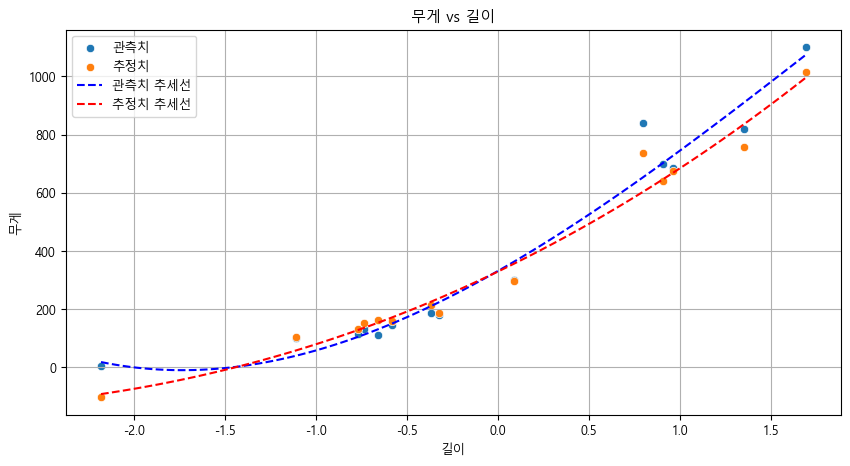

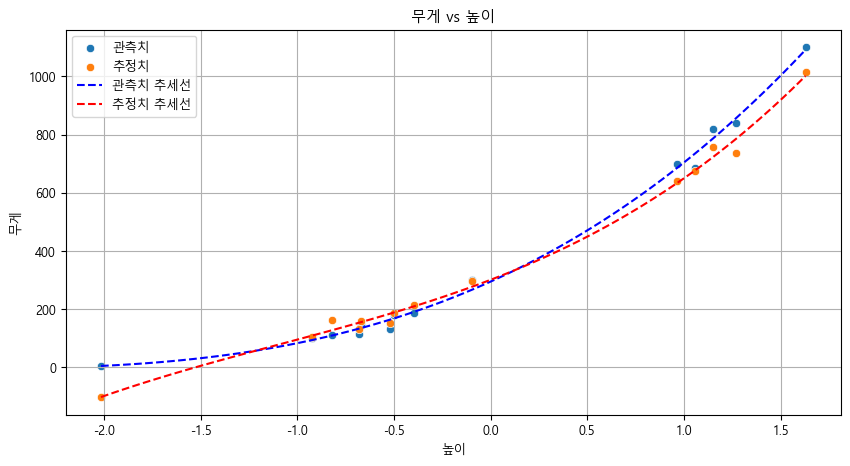

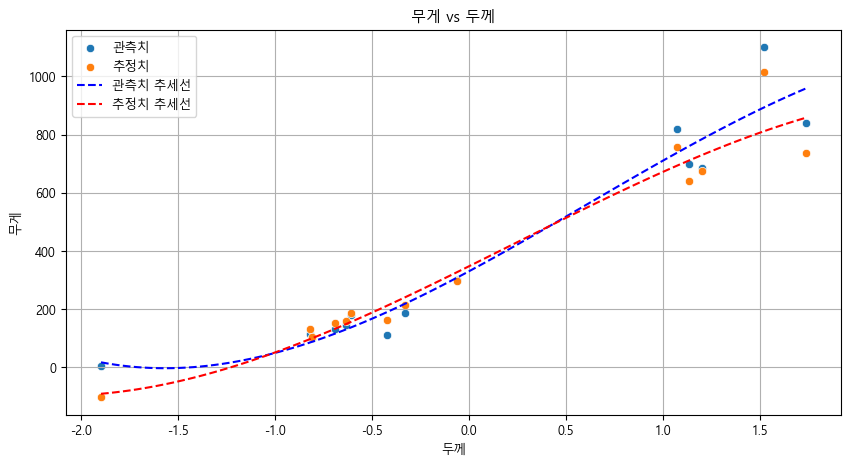

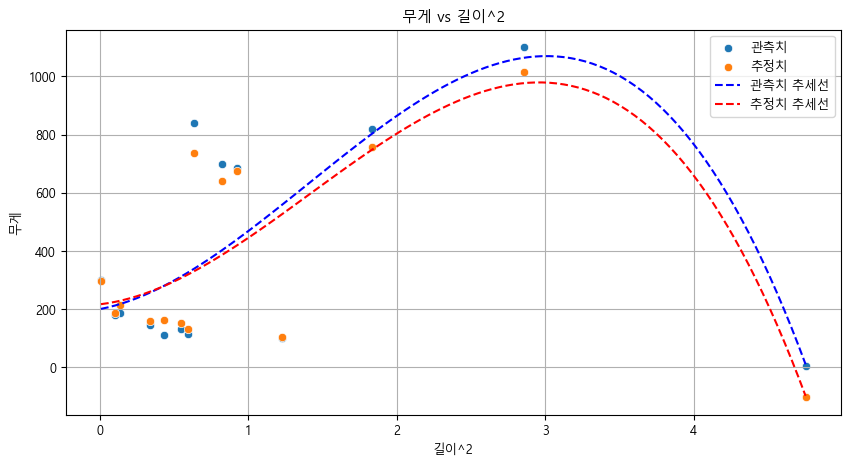

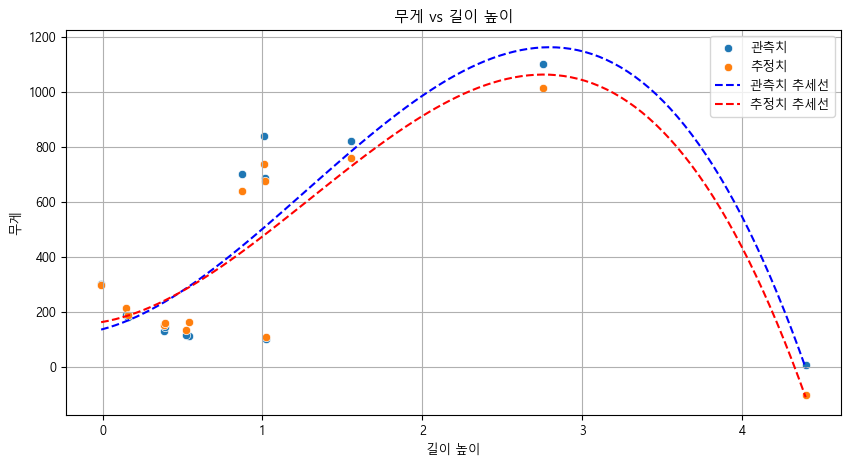

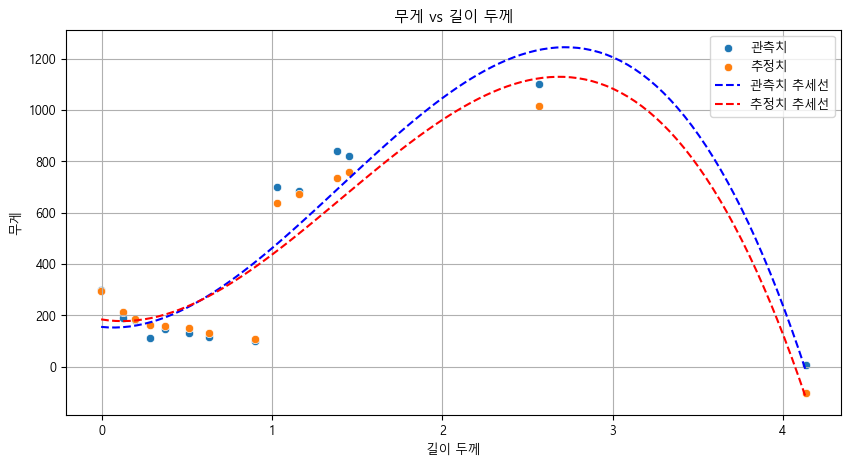

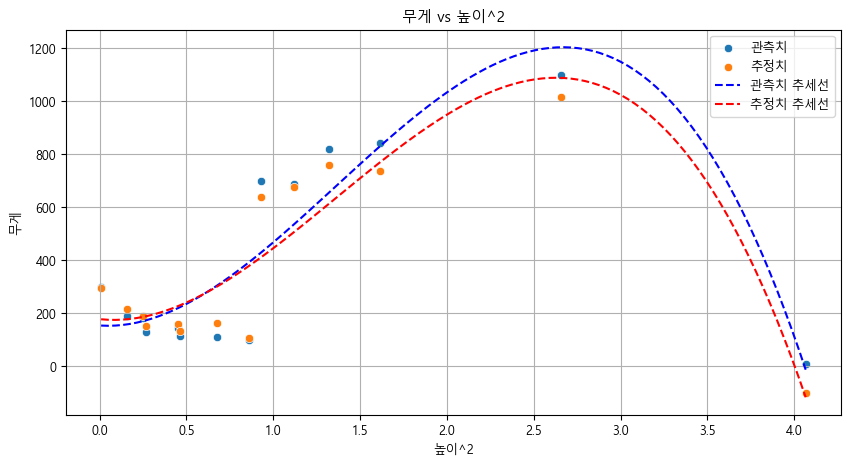

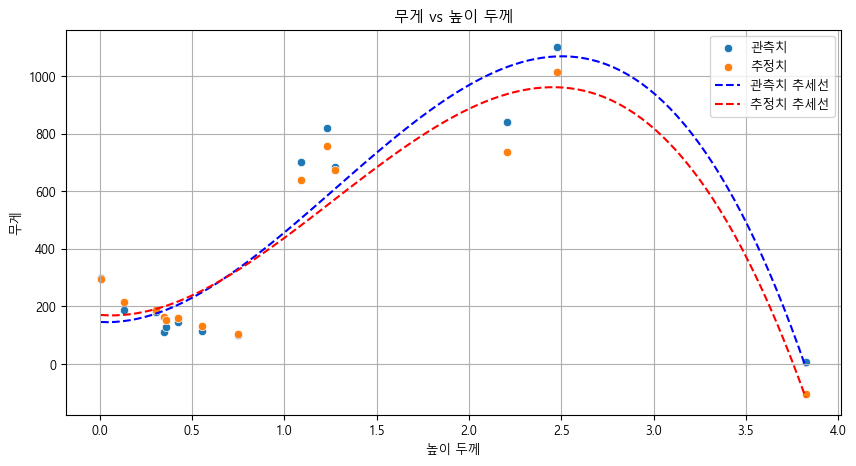

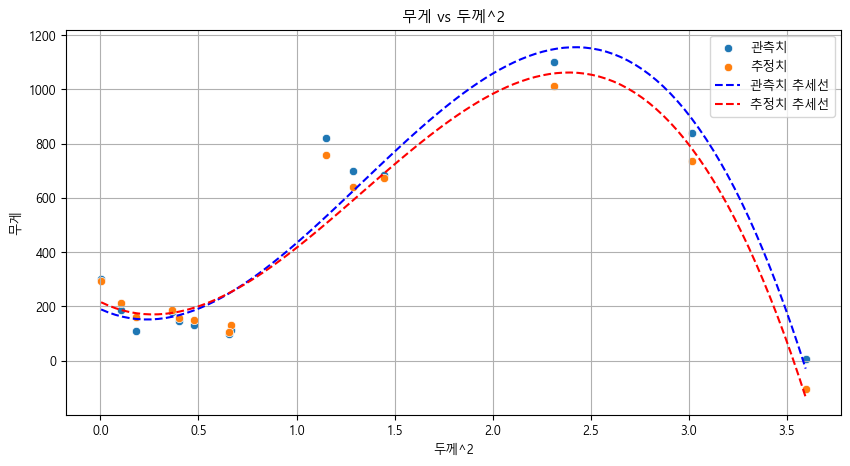

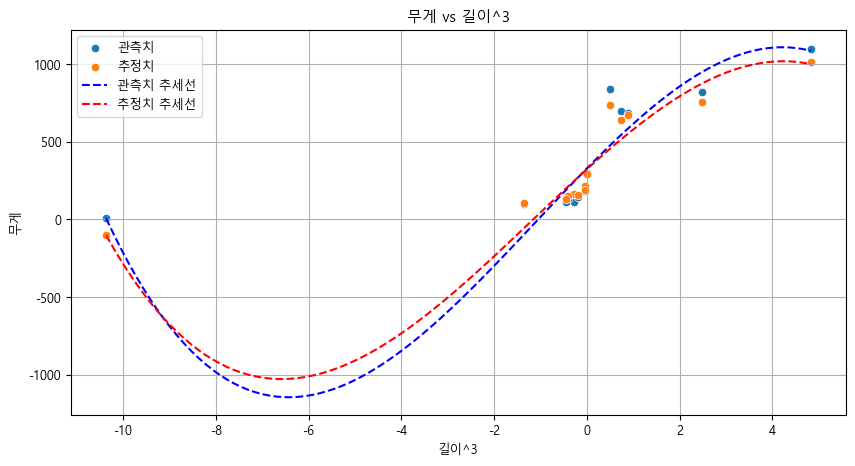

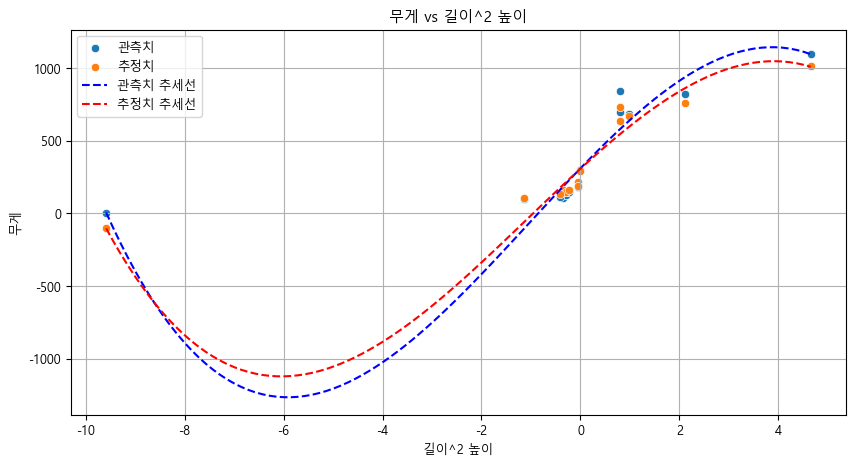

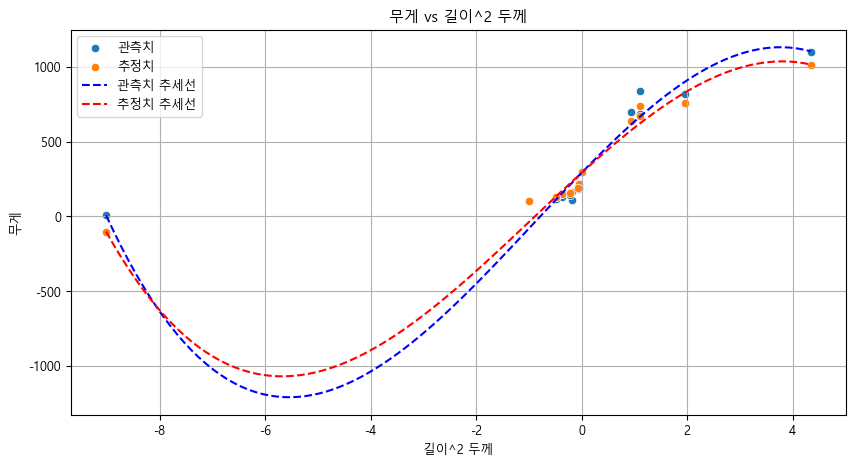

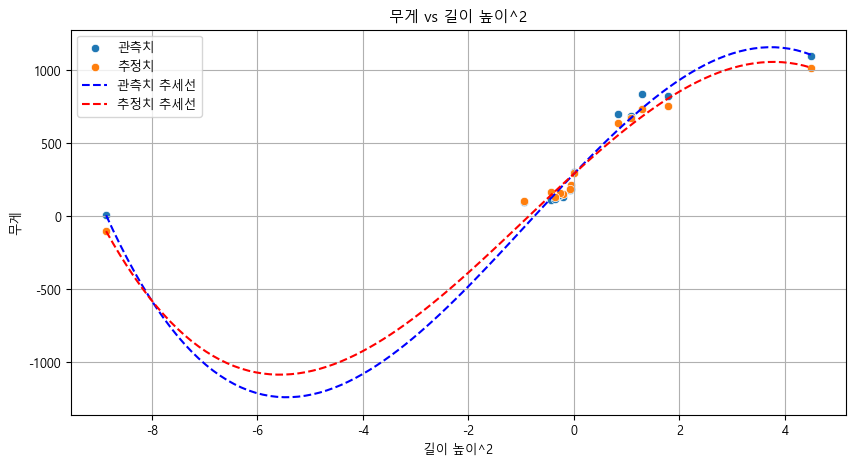

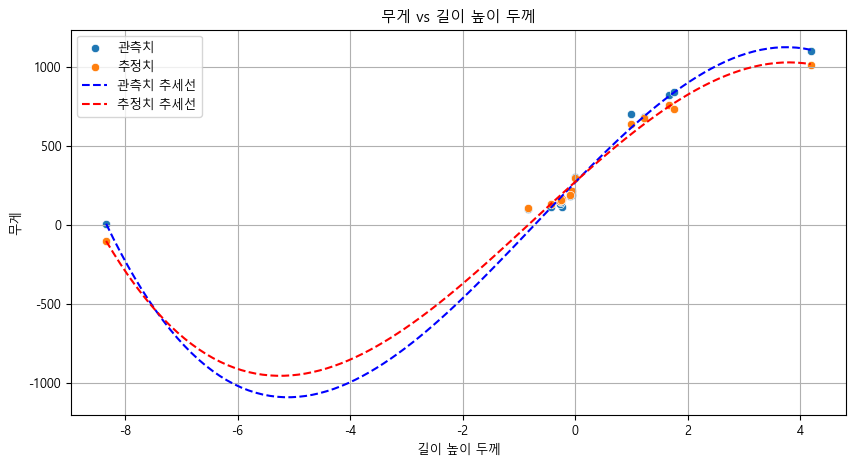

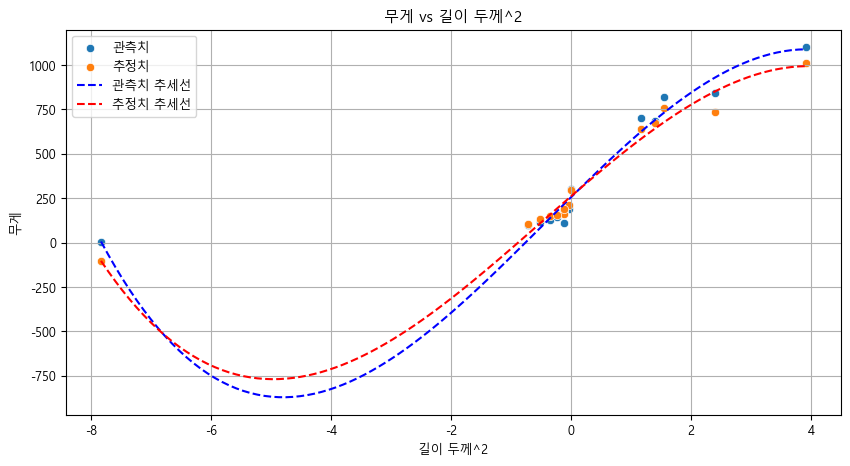

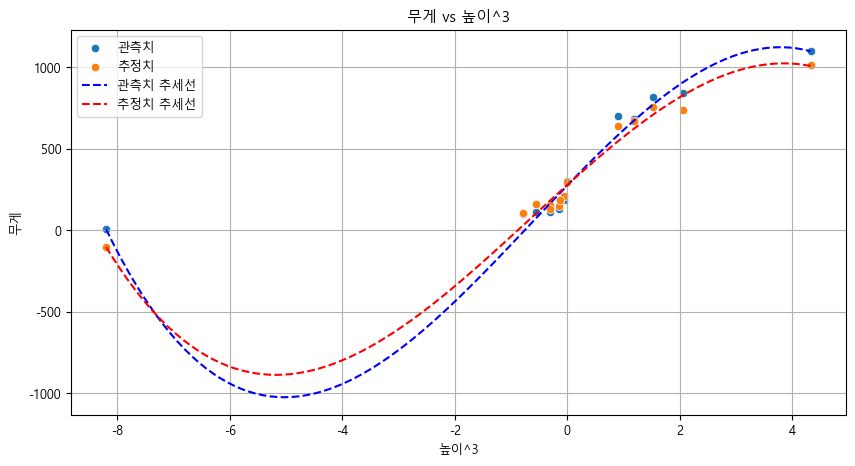

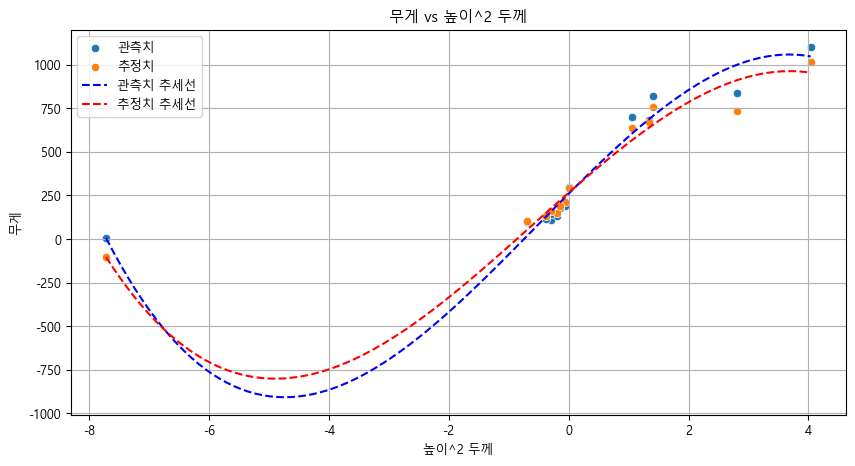

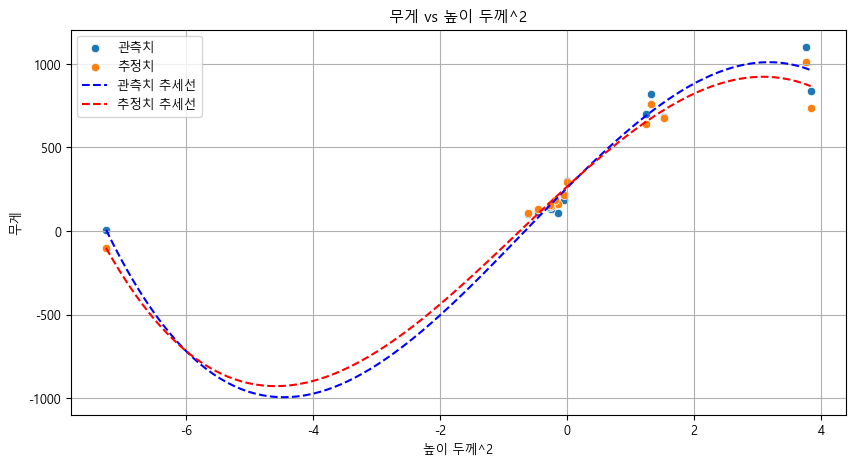

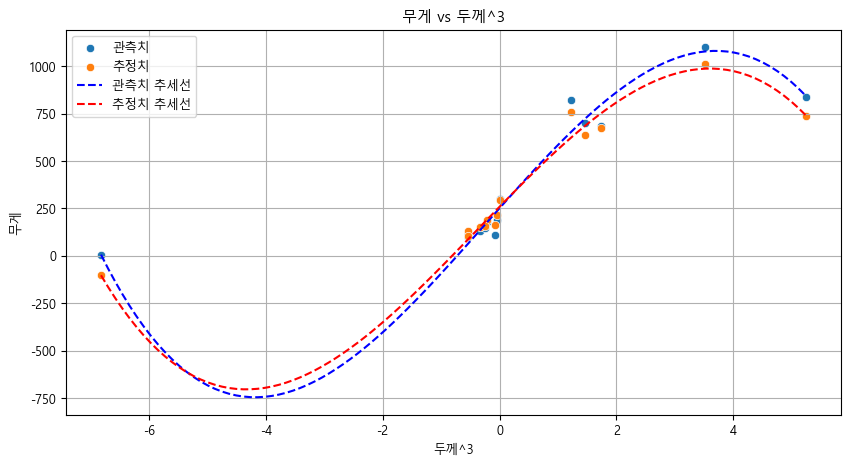



[잔차의 가정 확인] ==============================
[잔차의 선형성 가정]


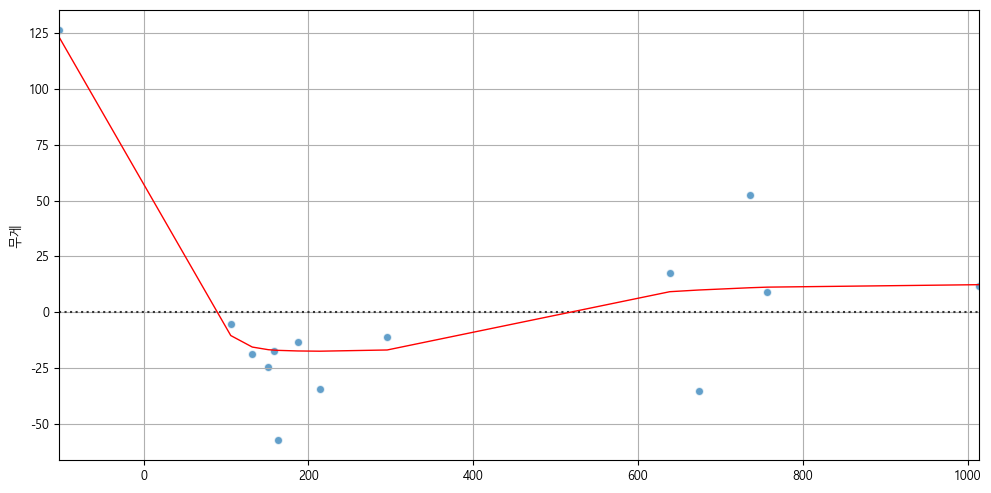


[잔차의 정규성 가정]


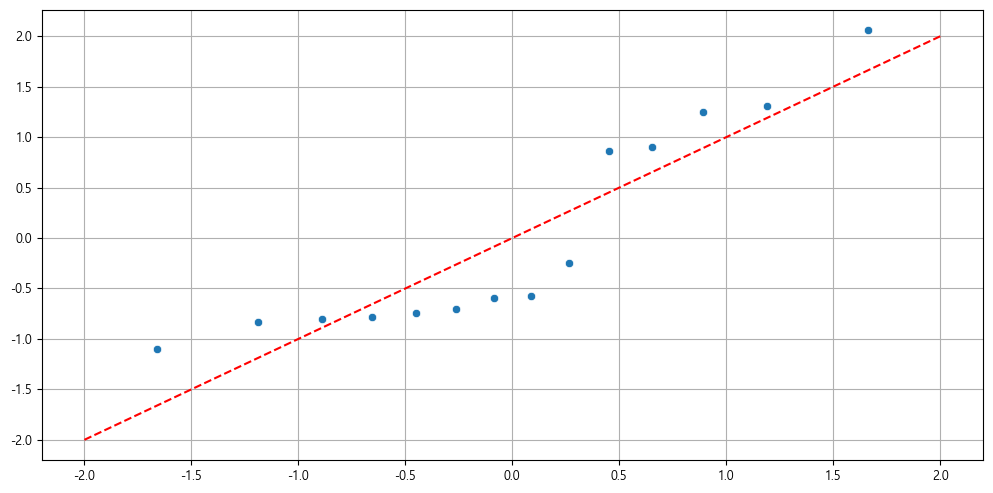

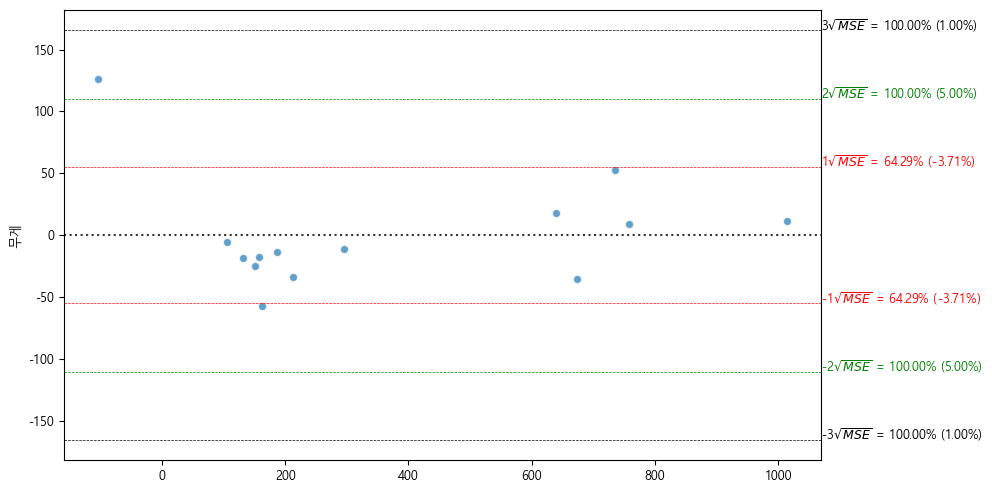

루트 1MSE 구간에 포함된 잔차 비율: 64.29% (-3.714285714285708)
루트 2MSE 구간에 포함된 잔차 비율: 100.00% (5.0)
루트 3MSE 구간에 포함된 잔차 비율: 100.00% (1.0)
잔차의 정규성 가정 충족 여부: False

[잔차의 등분산성 가정]
잔차의 등분산성 가정 충족 여부: True
+-----------+----------+
|           |   values |
|-----------+----------|
| statistic |       14 |
| p-value   | 0.783691 |
| f-value   |      nan |
| f p-value |      nan |
+-----------+----------+

[잔차의 독립성 가정]
Durbin-Watson: 2.2975894265797283, 잔차의 독립성 가정 만족 여부: True


In [19]:
model = my_lasso_regrassion(x_train,y_train,x_test,y_test, learning_curve=True, report=True, use_plot=True, degree=2, resid_test=True, dpi=100)